# Medical Insurance - Deep Learning

FL or no FL?

In [45]:
# import
#import dask.dataframe as dd
#from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
# Import the DNN functions
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow_addons.metrics import RSquare
import keras_tuner

import os
from datetime import datetime
from glob import glob

validation_split_size = 0.2

In [ ]:
os.chdir("..")

## Ingest

In [14]:
df = pd.read_csv("data/insurance-clean0.csv").iloc[:,1:]

In [18]:
from sklearn.model_selection import train_test_split
# Divide data into train and test data
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df_ml = df[features + [target]]

X_train, X_test, y_train, y_test = train_test_split(
    df_ml[features], df_ml[[target]], 
    test_size=0.2, random_state=42, shuffle = True)

In [20]:
X_train.head()

,age,sex,bmi,children,smoker,region0,region1,region2,region3
560,0.608696,0,0.107345,0.4,1,0.0,0.0,1.0,0.0
1285,0.630435,0,0.224913,0.0,1,0.0,0.0,0.0,1.0
1142,0.739130,0,0.239440,0.0,1,0.0,1.0,0.0,0.0
969,0.456522,0,0.493947,1.0,1,0.0,1.0,0.0,0.0
486,0.782609,0,0.148238,0.6,1,0.0,0.0,1.0,0.0


## DNN (centralized)

In [22]:
# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

In [25]:
# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    epochs=100)

Epoch 1/100
27/27 [==============================] - 1s 7ms/step - loss: 13517.7871 - mae: 13517.7871 - mean_squared_error: 325449856.0000 - r_square: -1.2804 - val_loss: 12653.6572 - val_mae: 12653.6572 - val_mean_squared_error: 310324576.0000 - val_r_square: -1.0660
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 13514.1826 - mae: 13514.1826 - mean_squared_error: 325358016.0000 - r_square: -1.2797 - val_loss: 12645.1904 - val_mae: 12645.1904 - val_mean_squared_error: 310125856.0000 - val_r_square: -1.0647
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 13437.6719 - mae: 13437.6719 - mean_squared_error: 323508896.0000 - r_square: -1.2668 - val_loss: 12099.7754 - val_mae: 12099.7754 - val_mean_squared_error: 297575136.0000 - val_r_square: -0.9811
Epoch 4/100
27/27 [==============================] - 0s 2ms/step - loss: 9276.7793 - mae: 9276.7793 - mean_squared_error: 206936144.0000 - r_square: -0.4500 - val_loss: 6887.1040 - val_mae: 688

### Diagnostics

In [28]:
def plot_loss(history, y_min=None, y_max=None, save_path=None):
    """Plot the training history and save the figure.

    :param history: The history object including the metrics to plot
    :type history: keras.callbacks.History
    :param y_min: The lover limit of the plot
    :type y_min: float, optional
    :param y_max: The upper limit of the plot
    :type y_max: float, optional
    :param save_path: The path to save the plot, if None, it will not be saved
    :type save_path: str, optional
    """
    plt.plot(history.history['r_square'], label='train R^2')
    plt.plot(history.history['val_r_square'], label='test R^2')
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path)

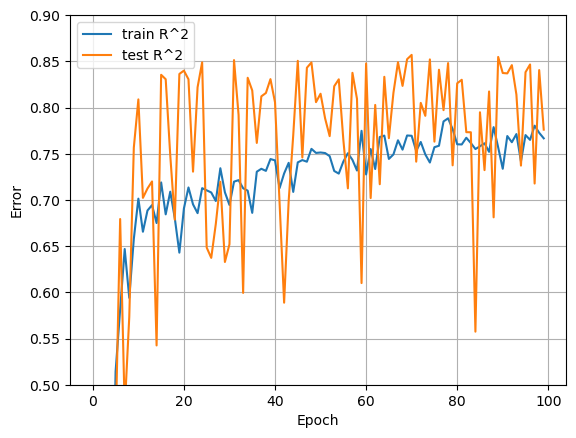

In [31]:
plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/medins_dnn_rsq.jpg")

- high Variance in training
- test > train

Why?

In [43]:
dnn_history.history

# val_* = validation loss, training set

dnn_history.history['val_r_square'][:10]


[-1.066004991531372,
 -1.0646817684173584,
 -0.981124758720398,
 0.04136455059051514,
 0.2049766182899475,
 0.4480707049369812,
 0.6793221235275269,
 0.47341299057006836,
 0.5732860565185547,
 0.7565833330154419]

## Experiments (centralized)

### Baseline

9/9 [==============================] - 0s 1ms/step - loss: 2642.2966 - mae: 2642.2966 - mean_squared_error: 24057256.0000 - r_square: 0.8450


[2642.296630859375, 2642.296630859375, 24057256.0, 0.8450405597686768]

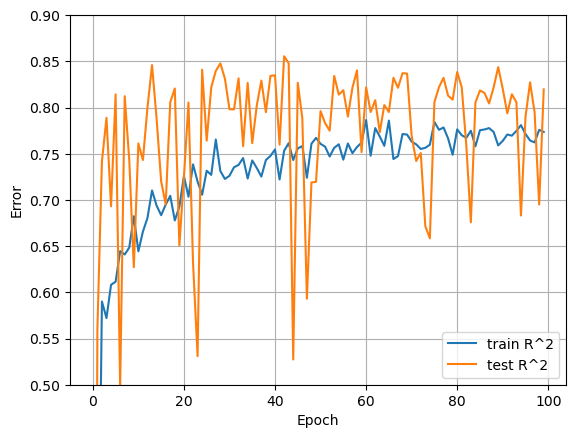

In [86]:
ex = "base100"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=100)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+ex_nr+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

In [51]:
perf = dnn_history.model.evaluate(X_test, y_test)
perf
# -> [3276.28369140625, 3276.28369140625, 30085684.0, 0.8062098026275635]

9/9 [==============================] - 0s 1ms/step - loss: 3276.2837 - mae: 3276.2837 - mean_squared_error: 30085684.0000 - r_square: 0.8062


[3276.28369140625, 3276.28369140625, 30085684.0, 0.8062098026275635]

### Lower Epochs

9/9 [==============================] - 0s 1ms/step - loss: 3104.7317 - mae: 3104.7317 - mean_squared_error: 35236600.0000 - r_square: 0.7730


[3104.731689453125, 3104.731689453125, 35236600.0, 0.7730313539505005]

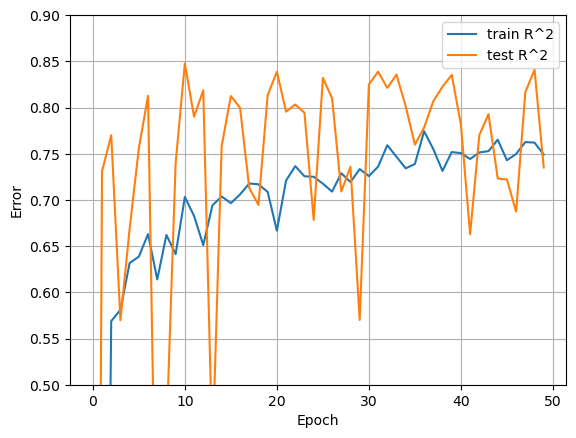

In [87]:
ex = "epoch50"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=50)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+ex_nr+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### No region

In [96]:
X_train_noregion = X_train.iloc[:,0:5]
X_test_noregion = X_test.iloc[:,0:5]

,age,sex,bmi,children,smoker
764,0.586957,0,0.247915,0.4,1
887,0.391304,0,0.378262,0.0,1
890,1.000000,0,0.293920,0.0,0
1293,0.608696,1,0.263250,0.6,1
259,0.021739,1,0.429379,0.0,0
...,...,...,...,...,...
109,0.978261,1,0.514662,0.0,0
575,0.869565,0,0.301587,0.0,1
535,0.434783,1,0.324590,0.2,1
543,0.782609,0,0.846112,0.0,0


9/9 [==============================] - 0s 1ms/step - loss: 3261.8765 - mae: 3261.8765 - mean_squared_error: 29557810.0000 - r_square: 0.8096


[3261.87646484375, 3261.87646484375, 29557810.0, 0.8096100091934204]

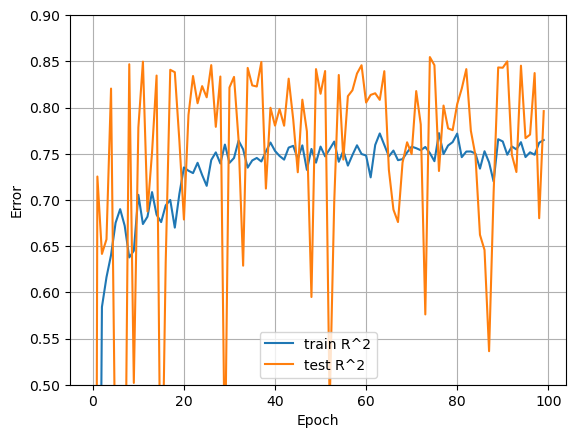

In [98]:
ex = "noregion"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(5,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train_noregion,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=100)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+ex_nr+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test_noregion, y_test)
perf

### Max Epoch

9/9 [==============================] - 0s 1ms/step - loss: 2421.8496 - mae: 2421.8496 - mean_squared_error: 26049472.0000 - r_square: 0.8322


[2421.849609375, 2421.849609375, 26049472.0, 0.8322081565856934]

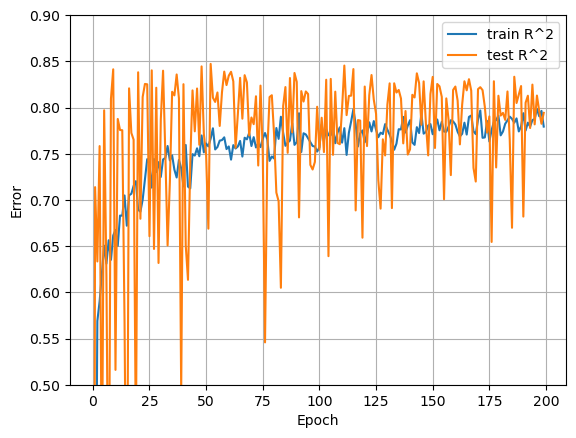

In [99]:
ex = "maxepoch200"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+ex_nr+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

9/9 [==============================] - 0s 1ms/step - loss: 2696.3665 - mae: 2696.3665 - mean_squared_error: 28416584.0000 - r_square: 0.8170


[2696.366455078125, 2696.366455078125, 28416584.0, 0.8169609308242798]

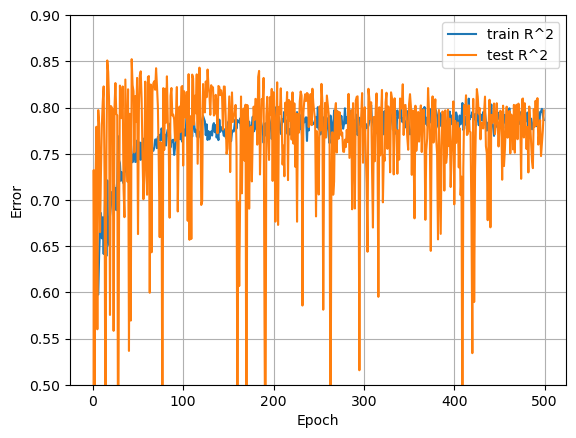

In [100]:
ex = "maxepoch500"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=500)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+ex_nr+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### Learning Rate

In [141]:
rate * 10000

25.0

9/9 [==============================] - 0s 974us/step - loss: 2088.2861 - mae: 2088.2861 - mean_squared_error: 20903340.0000 - r_square: 0.8654


[2088.2861328125, 2088.2861328125, 20903340.0, 0.8653558492660522]

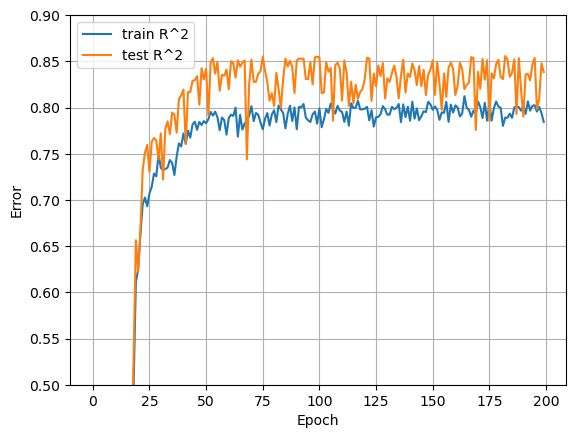

In [142]:
rate = .0025
ex = "learning_rate_" + str(round(rate * 10000)).zfill(5)
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(learning_rate = rate),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    #batch_size = 10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+"006_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### Low Rate + no Region

9/9 [==============================] - 0s 1ms/step - loss: 2698.9614 - mae: 2698.9614 - mean_squared_error: 25421154.0000 - r_square: 0.8363


[2698.96142578125, 2698.96142578125, 25421154.0, 0.8362553119659424]

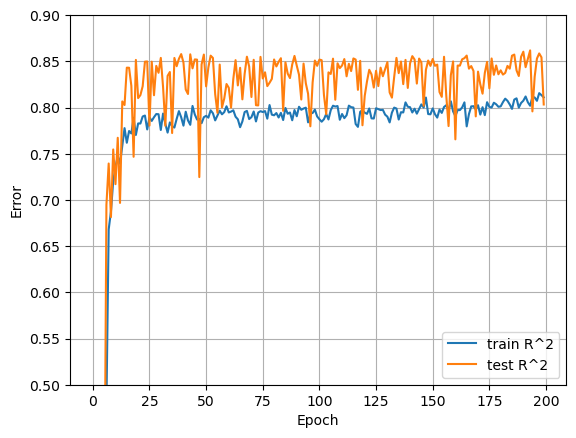

In [151]:
ex = "noregion_lowrate"
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(5,)),
    Dense(32, activation='relu'),
    Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(learning_rate = 0.0025),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train_noregion,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    batch_size=10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+"007"+"_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test_noregion, y_test)
perf

### No Dropout

9/9 [==============================] - 0s 1ms/step - loss: 2137.1235 - mae: 2137.1235 - mean_squared_error: 22386654.0000 - r_square: 0.8558


[2137.12353515625, 2137.12353515625, 22386654.0, 0.8558014035224915]

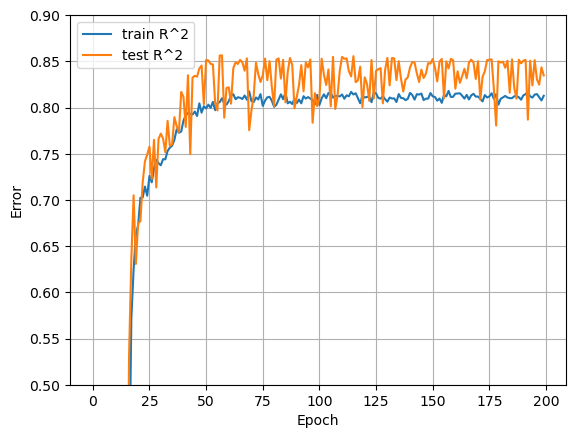

In [152]:
rate = .0025
ex = "nodrop_learning_rate_" + str(round(rate * 10000)).zfill(5)
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    #Dropout(0.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(learning_rate = rate),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    #batch_size = 10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+"007_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### High Dropout

9/9 [==============================] - 0s 1ms/step - loss: 2679.6582 - mae: 2679.6582 - mean_squared_error: 29452482.0000 - r_square: 0.8103


[2679.658203125, 2679.658203125, 29452482.0, 0.8102884292602539]

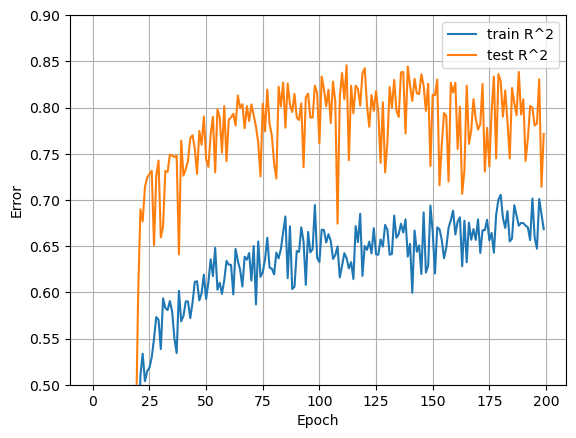

In [155]:
rate = .0025
ex = "highdrop_learning_rate_" + str(round(rate * 10000)).zfill(5)
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    Dropout(.6),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.SGD(learning_rate = rate),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    #batch_size = 10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+"008_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### Adam

In [158]:
tf.optimizers.Adam

keras.optimizers.optimizer_experimental.adam.Adam

9/9 [==============================] - 0s 1ms/step - loss: 1785.6361 - mae: 1785.6361 - mean_squared_error: 21798726.0000 - r_square: 0.8596


[1785.6361083984375, 1785.6361083984375, 21798726.0, 0.8595883846282959]

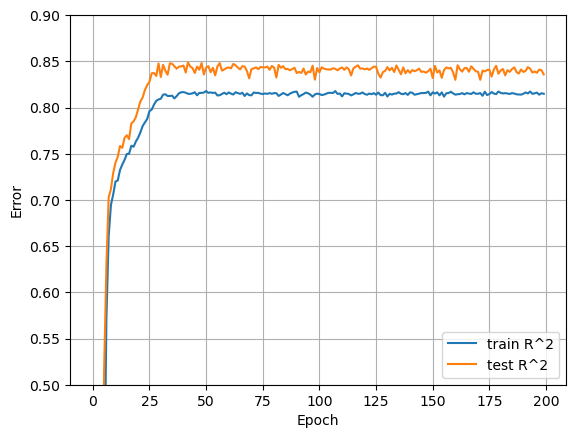

In [165]:
rate = .066
ex = "adam_learning_rate_" + str(round(rate * 10000)).zfill(5)
ex_nr = str(len(glob("output/plots/*medins*")) + 1).zfill(3)

# DNN: compose and compile
dnn_model = Sequential([
    keras.Input(shape=(9,)),
    Dense(32, activation='relu'),
    #Dropout(.05),
    Dense(16, activation='relu'),
    Dense(1)
])

dnn_model.compile(loss=tf.losses.mae,
                  optimizer=tf.optimizers.Adam(learning_rate = rate),
                  metrics=["mae", 'mean_squared_error', RSquare()]
                  )

# DNN: train
dnn_history = dnn_model.fit(
    X_train,
    y_train,
    shuffle=True,
    validation_split=validation_split_size,
    #batch_size = 10, 
    verbose=0,
    epochs=200)

cur_time = datetime.now().strftime("%Y%m%d-%H%M%S")

plot_loss(
    dnn_history, y_min=0.5, y_max=0.9, 
    save_path="output/plots/"+"009_medins_dnn_experiment_"+ ex +"-"+cur_time+".jpg")

perf = dnn_history.model.evaluate(X_test, y_test)
perf

### Test Performance over Train Performance?

for test over train:
- https://twitter.com/aureliengeron/status/1110839345609465856
- reason often regularization, e.g. dropout

In [149]:


dnn_history.model.predict(X_train)

34/34 [==============================] - 0s 576us/step


array([[ 9544.986],
       [ 9265.446],
       [10368.177],
       ...,
       [12497.053],
       [59540.688],
       [10991.06 ]], dtype=float32)